<a href="https://colab.research.google.com/github/1489685175z-coder/Bird_Speicy_Classification/blob/main/Bird_Speicy_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Project: Fine-Grained Bird Species Classification on CUB-200-2011
# Compare: Pretrained ResNet-18 vs Pretrained ViT

# =============================================================================
# 1. Install dependencies (if needed in Colab)
# =============================================================================
!pip install -q transformers datasets torch torchvision scikit-learn matplotlib pillow tqdm evaluate
!pip install seaborn
# =============================================================================
# 2. Import libraries
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from transformers import ViTForImageClassification
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00


In [2]:
# =============================================================================
# 3. Device & Hyperparameters
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 32  # Compromise between originals (16 for ViT, 64 for ResNet)
NUM_EPOCHS = 30   # Balanced for comparison
NUM_CLASSES = 200

models_config = [
    {"name": "resnet18", "pretrained": True, "lr": 0.001},
    {"name": "vit", "pretrained": True, "lr": 3e-5}
]


Using device: cuda


In [3]:
# =============================================================================
# 4. Load Dataset from Hugging Face
# =============================================================================
print("Loading dataset...")
hf_dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

class_names = hf_dataset['train'].features['label'].names  # Get class names for reporting

class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_ds = CUBDataset(hf_dataset['train'], train_transform)
test_ds = CUBDataset(hf_dataset['test'], test_transform)

train_size = int(0.85 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")
print(f"Num classes: {NUM_CLASSES}, Example classes: {class_names[:5]}...")


Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/296M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5794 [00:00<?, ? examples/s]

Train samples: 5094, Val samples: 900, Test samples: 5794
Num classes: 200, Example classes: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']...


In [4]:
# =============================================================================
# 5. Train and Evaluate Functions (Unified for both models)
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, scaler, device, model_name):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += images.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device, model_name, is_test=False):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += images.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if is_test:
                all_logits.extend(outputs.cpu().numpy())  # For top-5
    acc = correct / total
    loss = total_loss / total
    top5_acc = top_k_accuracy_score(all_labels, all_logits, k=5) if is_test else None
    return loss, acc, top5_acc, all_preds, all_labels


In [5]:
# =============================================================================
# 6. Main Training Loop
# =============================================================================
all_history = {}
test_results = {}
for config in models_config:
    name = config["name"]
    print(f"\n=== Training {name} ===")
    if name == "resnet18":
        model = models.resnet18(pretrained=config["pretrained"])
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
        # Freeze all except last layer and classifier (as in original ResNet)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif name == "vit":
        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=NUM_CLASSES,
            ignore_mismatched_sizes=True
        )
        # No freezing in original ViT, so train all with small LR

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=0.01)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "train_time": []}
    best_val_acc = 0.0
    t_start = time.time()

    for epoch in range(NUM_EPOCHS):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device, name)
        va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, device, name)
        scheduler.step(va_acc)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        epoch_time = time.time() - t_start
        history["train_time"].append(epoch_time)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            torch.save(model.state_dict(), f"best_{name}.pth")

    total_train_time = time.time() - t_start
    print(f"Total training time for {name}: {total_train_time:.1f}s")

    # Load best model for test
    model.load_state_dict(torch.load(f"best_{name}.pth", map_location=device))
    te_loss, te_acc, te_top5_acc, te_preds, te_labels = evaluate(model, test_loader, criterion, device, name, is_test=True)
    report = classification_report(te_labels, te_preds, target_names=class_names, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']

    test_results[name] = {
        "acc": te_acc,
        "top5_acc": te_top5_acc,
        "macro_f1": macro_f1,
        "train_time": total_train_time,
        "preds": te_preds,
        "labels": te_labels
    }
    all_history[name] = history

    # Per-model error analysis (top-5 confused pairs)
    errors = [(true, pred) for true, pred in zip(te_labels, te_preds) if true != pred]
    if errors:
        most_common_errors = Counter(errors).most_common(5)
        print(f"Top 5 confused pairs for {name} (True → Predicted):")
        for (true_label, pred_label), count in most_common_errors:
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            print(f"  {true_name} → {pred_name} : {count} times")


=== Training resnet18 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 74.0MB/s]
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Evaluating: 100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


Epoch 1/30 | Train Loss: 4.3806 Acc: 0.1247 | Val Loss: 3.6569 Acc: 0.2144


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


Epoch 2/30 | Train Loss: 3.3286 Acc: 0.3059 | Val Loss: 3.4200 Acc: 0.2778


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.20it/s]


Epoch 3/30 | Train Loss: 2.9782 Acc: 0.4050 | Val Loss: 3.0694 Acc: 0.3722


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.30it/s]


Epoch 4/30 | Train Loss: 2.7338 Acc: 0.4700 | Val Loss: 2.9973 Acc: 0.4133


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.22it/s]


Epoch 5/30 | Train Loss: 2.6040 Acc: 0.5049 | Val Loss: 2.9069 Acc: 0.4511


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


Epoch 6/30 | Train Loss: 2.4760 Acc: 0.5528 | Val Loss: 2.9198 Acc: 0.4267


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.19it/s]


Epoch 7/30 | Train Loss: 2.3627 Acc: 0.5832 | Val Loss: 2.8446 Acc: 0.4556


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


Epoch 8/30 | Train Loss: 2.2814 Acc: 0.6184 | Val Loss: 2.8227 Acc: 0.4844


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]


Epoch 9/30 | Train Loss: 2.2262 Acc: 0.6392 | Val Loss: 2.7520 Acc: 0.4922


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]


Epoch 10/30 | Train Loss: 2.1808 Acc: 0.6508 | Val Loss: 2.6660 Acc: 0.5100


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.83it/s]


Epoch 11/30 | Train Loss: 2.1028 Acc: 0.6792 | Val Loss: 2.7792 Acc: 0.4922


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]


Epoch 12/30 | Train Loss: 2.0455 Acc: 0.6996 | Val Loss: 2.7283 Acc: 0.5111


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]


Epoch 13/30 | Train Loss: 2.0204 Acc: 0.7000 | Val Loss: 2.7075 Acc: 0.4867


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.86it/s]


Epoch 14/30 | Train Loss: 1.9633 Acc: 0.7201 | Val Loss: 2.6646 Acc: 0.5222


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]


Epoch 15/30 | Train Loss: 1.9073 Acc: 0.7424 | Val Loss: 2.7103 Acc: 0.5300


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.50it/s]


Epoch 16/30 | Train Loss: 1.8982 Acc: 0.7527 | Val Loss: 2.6977 Acc: 0.5167


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]


Epoch 17/30 | Train Loss: 1.8832 Acc: 0.7507 | Val Loss: 2.6827 Acc: 0.5144


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.57it/s]


Epoch 18/30 | Train Loss: 1.8742 Acc: 0.7513 | Val Loss: 2.7654 Acc: 0.5100


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.55it/s]


Epoch 19/30 | Train Loss: 1.7259 Acc: 0.8074 | Val Loss: 2.6048 Acc: 0.5322


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


Epoch 20/30 | Train Loss: 1.6258 Acc: 0.8353 | Val Loss: 2.6275 Acc: 0.5433


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


Epoch 21/30 | Train Loss: 1.6355 Acc: 0.8320 | Val Loss: 2.6144 Acc: 0.5444


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


Epoch 22/30 | Train Loss: 1.6130 Acc: 0.8373 | Val Loss: 2.5710 Acc: 0.5644


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


Epoch 23/30 | Train Loss: 1.5878 Acc: 0.8447 | Val Loss: 2.5681 Acc: 0.5533


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]


Epoch 24/30 | Train Loss: 1.5628 Acc: 0.8496 | Val Loss: 2.5767 Acc: 0.5511


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


Epoch 25/30 | Train Loss: 1.5664 Acc: 0.8502 | Val Loss: 2.5123 Acc: 0.5600


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.05it/s]


Epoch 26/30 | Train Loss: 1.5135 Acc: 0.8655 | Val Loss: 2.5159 Acc: 0.5756


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.94it/s]


Epoch 27/30 | Train Loss: 1.4990 Acc: 0.8669 | Val Loss: 2.5137 Acc: 0.5756


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.09it/s]


Epoch 28/30 | Train Loss: 1.4828 Acc: 0.8720 | Val Loss: 2.5393 Acc: 0.5711


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.12it/s]


Epoch 29/30 | Train Loss: 1.4666 Acc: 0.8799 | Val Loss: 2.5228 Acc: 0.5800


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.01it/s]


Epoch 30/30 | Train Loss: 1.4591 Acc: 0.8793 | Val Loss: 2.5326 Acc: 0.5900
Total training time for resnet18: 1222.1s


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.87it/s]


Top 5 confused pairs for resnet18 (True → Predicted):
  051.Horned_Grebe → 050.Eared_Grebe : 9 times
  111.Loggerhead_Shrike → 112.Great_Grey_Shrike : 9 times
  131.Vesper_Sparrow → 127.Savannah_Sparrow : 9 times
  144.Common_Tern → 146.Forsters_Tern : 9 times
  145.Elegant_Tern → 143.Caspian_Tern : 9 times

=== Training vit ===


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.bias     | MISSING    | 
classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enab

Epoch 1/30 | Train Loss: 5.1918 Acc: 0.1042 | Val Loss: 5.0543 Acc: 0.2811


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.64it/s]


Epoch 2/30 | Train Loss: 4.8789 Acc: 0.4521 | Val Loss: 4.7292 Acc: 0.5111


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 3/30 | Train Loss: 4.5388 Acc: 0.6007 | Val Loss: 4.4151 Acc: 0.5900


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 4/30 | Train Loss: 4.2162 Acc: 0.6663 | Val Loss: 4.1240 Acc: 0.6233


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 5/30 | Train Loss: 3.9093 Acc: 0.6989 | Val Loss: 3.8392 Acc: 0.6611


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 6/30 | Train Loss: 3.6136 Acc: 0.7163 | Val Loss: 3.5729 Acc: 0.6756


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]


Epoch 7/30 | Train Loss: 3.3258 Acc: 0.7458 | Val Loss: 3.3391 Acc: 0.6733


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 8/30 | Train Loss: 3.0462 Acc: 0.7583 | Val Loss: 3.0656 Acc: 0.6956


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


Epoch 9/30 | Train Loss: 2.7962 Acc: 0.7768 | Val Loss: 2.8595 Acc: 0.7078


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 10/30 | Train Loss: 2.5624 Acc: 0.7874 | Val Loss: 2.6557 Acc: 0.7100


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Epoch 11/30 | Train Loss: 2.3497 Acc: 0.8039 | Val Loss: 2.4886 Acc: 0.7333


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


Epoch 12/30 | Train Loss: 2.1664 Acc: 0.8190 | Val Loss: 2.3232 Acc: 0.7233


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.70it/s]


Epoch 13/30 | Train Loss: 1.9769 Acc: 0.8357 | Val Loss: 2.1874 Acc: 0.7533


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 14/30 | Train Loss: 1.8759 Acc: 0.8347 | Val Loss: 2.1044 Acc: 0.7378


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]


Epoch 15/30 | Train Loss: 1.7879 Acc: 0.8386 | Val Loss: 2.0061 Acc: 0.7467


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Epoch 16/30 | Train Loss: 1.6416 Acc: 0.8651 | Val Loss: 1.9342 Acc: 0.7500


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 17/30 | Train Loss: 1.5697 Acc: 0.8761 | Val Loss: 1.8875 Acc: 0.7667


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 18/30 | Train Loss: 1.5293 Acc: 0.8808 | Val Loss: 1.8484 Acc: 0.7689


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 19/30 | Train Loss: 1.4934 Acc: 0.8883 | Val Loss: 1.8608 Acc: 0.7578


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 20/30 | Train Loss: 1.4706 Acc: 0.8838 | Val Loss: 1.8088 Acc: 0.7722


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 21/30 | Train Loss: 1.4104 Acc: 0.8971 | Val Loss: 1.7957 Acc: 0.7744


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 22/30 | Train Loss: 1.3931 Acc: 0.8946 | Val Loss: 1.7794 Acc: 0.7656


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 23/30 | Train Loss: 1.3599 Acc: 0.9022 | Val Loss: 1.7577 Acc: 0.7700


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.81it/s]


Epoch 24/30 | Train Loss: 1.3675 Acc: 0.8997 | Val Loss: 1.6895 Acc: 0.7856


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Epoch 25/30 | Train Loss: 1.3420 Acc: 0.8983 | Val Loss: 1.7052 Acc: 0.7800


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


Epoch 26/30 | Train Loss: 1.3052 Acc: 0.9069 | Val Loss: 1.7170 Acc: 0.7711


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.81it/s]


Epoch 27/30 | Train Loss: 1.3161 Acc: 0.9022 | Val Loss: 1.6486 Acc: 0.7833


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 28/30 | Train Loss: 1.2720 Acc: 0.9136 | Val Loss: 1.6684 Acc: 0.7822


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Epoch 29/30 | Train Loss: 1.2473 Acc: 0.9201 | Val Loss: 1.7499 Acc: 0.7622


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.81it/s]


Epoch 30/30 | Train Loss: 1.2706 Acc: 0.9119 | Val Loss: 1.7105 Acc: 0.7744
Total training time for vit: 1749.9s


Evaluating: 100%|██████████| 182/182 [01:03<00:00,  2.85it/s]


Top 5 confused pairs for vit (True → Predicted):
  059.California_Gull → 066.Western_Gull : 13 times
  071.Long_tailed_Jaeger → 072.Pomarine_Jaeger : 11 times
  025.Pelagic_Cormorant → 024.Red_faced_Cormorant : 10 times
  037.Acadian_Flycatcher → 039.Least_Flycatcher : 10 times
  062.Herring_Gull → 060.Glaucous_winged_Gull : 9 times



=== Model Comparison ===
| Model    |   Test Accuracy |   Test Top-5 Accuracy |   Macro F1-Score |   Total Train Time (s) |
|:---------|----------------:|----------------------:|-----------------:|-----------------------:|
| resnet18 |          0.6859 |                0.888  |           0.6833 |                 1222.1 |
| vit      |          0.8766 |                0.9802 |           0.8738 |                 1749.9 |


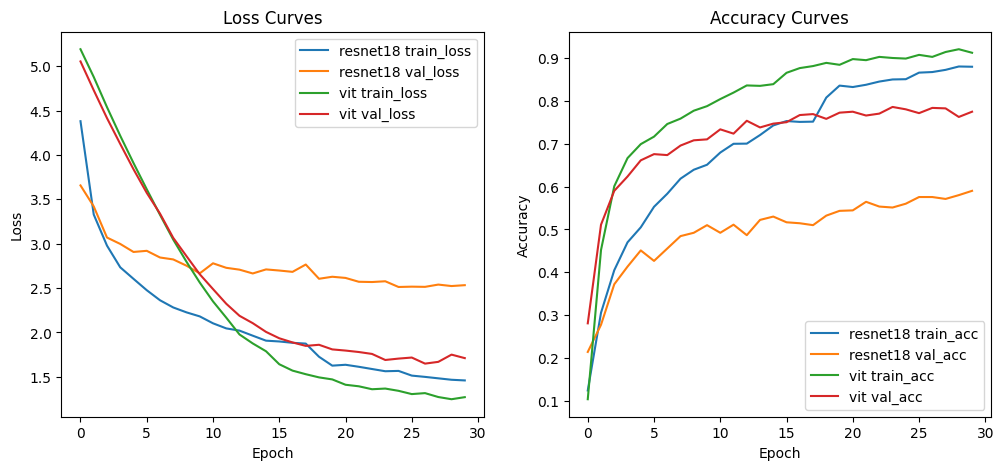

In [6]:

# =============================================================================
# 7. Compare Models
# =============================================================================
print("\n=== Model Comparison ===")
comparison_data = {
    "Model": list(test_results.keys()),
    "Test Accuracy": [f"{test_results[m]['acc']:.4f}" for m in test_results],
    "Test Top-5 Accuracy": [f"{test_results[m]['top5_acc']:.4f}" for m in test_results],
    "Macro F1-Score": [f"{test_results[m]['macro_f1']:.4f}" for m in test_results],
    "Total Train Time (s)": [f"{test_results[m]['train_time']:.1f}" for m in test_results]
}
print(pd.DataFrame(comparison_data).to_markdown(index=False))  # Requires import pandas as pd if needed

# Plot combined curves
plt.figure(figsize=(12, 5))
for name in all_history:
    plt.subplot(1, 2, 1)
    plt.plot(all_history[name]["train_loss"], label=f"{name} train_loss")
    plt.plot(all_history[name]["val_loss"], label=f"{name} val_loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_history[name]["train_acc"], label=f"{name} train_acc")
    plt.plot(all_history[name]["val_acc"], label=f"{name} val_acc")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()


=== Plotting Confusion Matrices ===


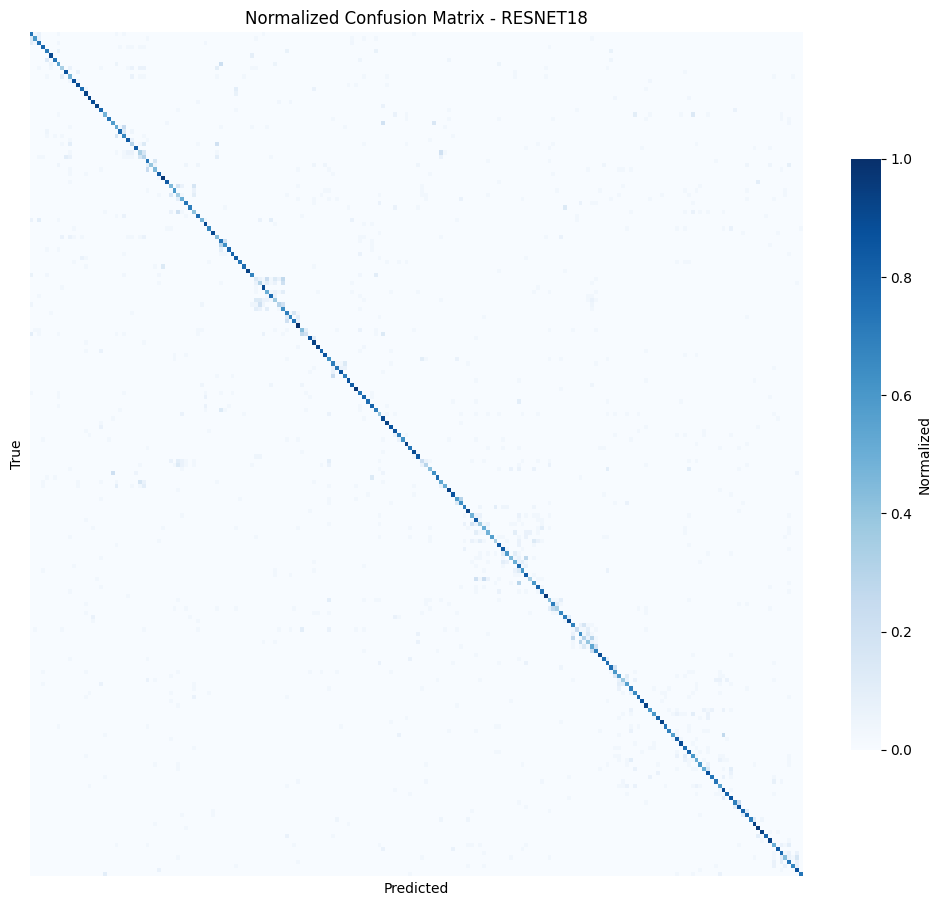

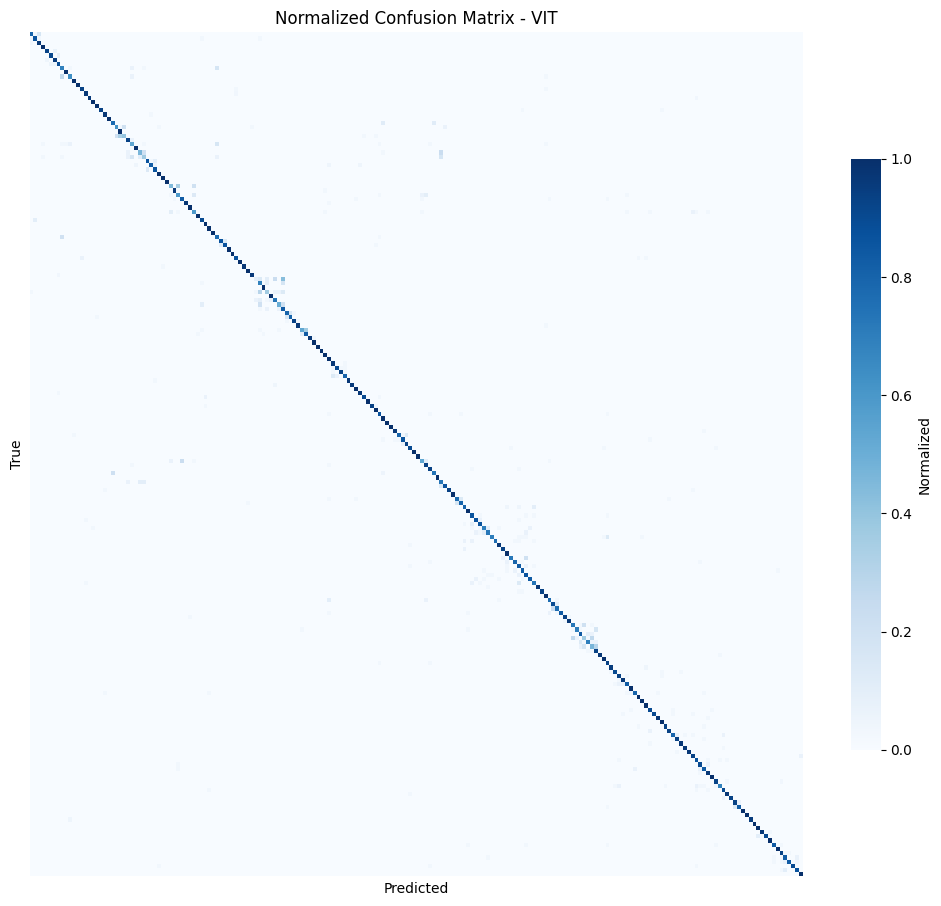

In [7]:
# =============================================================================
# 8. Plot Confusion Matrices for Both Models
# =============================================================================
print("\n=== Plotting Confusion Matrices ===")

for name in test_results:
    y_true = test_results[name]['labels']   # list or np.array of true labels
    y_pred = test_results[name]['preds']    # list or np.array of predicted labels

    # Compute Confusion Matrice (200x200)
    cm = confusion_matrix(y_true, y_pred)

    # Normalized (row-normalized to 1, easier to see error distribution)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)


    plt.figure(figsize=(10, 9))
    sns.heatmap(
        cm_normalized,
        cmap='Blues',
        annot=False,
        xticklabels=False,
        yticklabels=False,
        square=False,
        cbar_kws={'label': 'Normalized', 'shrink': 0.7}
    )
    plt.title(f'Normalized Confusion Matrix - {name.upper()}', fontsize=12)
    plt.ylabel('True', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'cm_{name}_small.png', dpi=200, bbox_inches='tight')
    plt.show()